In [2]:
pip install pyepo

Note: you may need to restart the kernel to use updated packages.


Todo la informacion fue extraida de https://khalil-research.github.io/PyEPO y https://github.com/khalil-research/PyEPO?tab=readme-ov-file

In [4]:
import pyepo

Auto-Sklearn cannot be imported.


In [5]:
import pyepo
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 7 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=73)
#73 Sheldon Cooper reference

Construir el Modelo

In [7]:
import pyepo

grid = (5,5) # network grid
optmodel = pyepo.model.grb.shortestPathModel(grid) # build model

Restricted license - for non-production use only - expires 2025-11-24


Dataset y Data Loader


-Dataset es una clase en PyTorch que almacena las muestras de datos y sus etiquetas(features) correspondientes.

-DataLoader se utiliza para acceder de manera eficiente a las muestras de datos almacenadas en optDataset.

In [11]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=73)

In [12]:
# get optDataset
dataset_train = pyepo.data.dataset.optDataset(optmodel, x_train, c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:03<00:00, 295.51it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:02<00:00, 368.46it/s]


In [13]:
# set data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Generar Datos para el Problema del Camino Más Corto:

Regresion lineal en Pytorch

In [16]:
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

In [17]:
import torch
# init model
reg = LinearRegression()

-Entrenamiento y testeo

To calculate regret, ``pyepo.metric.regret`` requires:
- ``predmodel``: a regression neural network for cost prediction
- ``optmodel``: an PyEPO optimization model
- ``dataloader``: PyTorch dataloader from optDataset to evaluate

The following code block is an example:

In [20]:
import pyepo
regret = pyepo.metric.regret(reg, optmodel, loader_test)

Funciones para entrenar el modelo con diferentes metodos

In [22]:
import time

# train model
def trainModel(reg, loss_func, method_name, num_epochs=20, lr=1e-2):
    # set adam optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # train mode
    reg.train()
    # init log
    loss_log = []
    loss_log_regret = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # init elpased time
    elapsed = 0
    for epoch in range(num_epochs):
        # start timing
        tick = time.time()
        # load data
        for i, data in enumerate(loader_train):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            if method_name in ["ptb", "pfy", "imle", "nce", "cmap"]:
                loss = loss_func(cp, w)
            if method_name in ["dbb", "nid"]:
                loss = loss_func(cp, c, z)
            if method_name == "ltr":
                loss = loss_func(cp, c)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record time
            tock = time.time()
            elapsed += tock - tick
            # log
            loss_log.append(loss.item())
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        loss_log_regret.append(regret)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

Graficador

In [24]:
from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(loss_log, color="c", lw=1)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    # draw plot for regret on test
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.5)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

Resolucion de SPO+

In [26]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [27]:
import pyepo 
spop = pyepo.func.SPOPlus(optmodel, processes=2) 

Num of cores: 2


Entrenamiento SPO+

In [29]:
loss_log, loss_log_regret = trainModel(reg, loss_func=spop, method_name="spo+")

Epoch  1,  Loss:    1.2293,  Regret:  9.9658%
Epoch  2,  Loss:    1.0717,  Regret:  8.7769%
Epoch  3,  Loss:    1.2903,  Regret:  9.3087%
Epoch  4,  Loss:    2.1096,  Regret:  8.6375%
Epoch  5,  Loss:    0.5339,  Regret:  8.8509%
Epoch  6,  Loss:    2.2915,  Regret:  8.7016%
Epoch  7,  Loss:    1.5952,  Regret:  8.3029%
Epoch  8,  Loss:    2.0875,  Regret:  9.1300%
Epoch  9,  Loss:    0.6717,  Regret:  8.8900%
Epoch 10,  Loss:    1.4067,  Regret:  8.6186%
Epoch 11,  Loss:    1.0936,  Regret:  8.9596%
Epoch 12,  Loss:    0.8332,  Regret:  8.9474%
Epoch 13,  Loss:    0.9403,  Regret:  9.0358%
Epoch 14,  Loss:    1.6259,  Regret:  8.9663%
Epoch 15,  Loss:    1.4773,  Regret:  8.8037%
Epoch 16,  Loss:    1.9574,  Regret:  9.1609%
Epoch 17,  Loss:    1.6634,  Regret:  8.8926%
Epoch 18,  Loss:    0.5721,  Regret:  8.8587%
Epoch 19,  Loss:    1.3262,  Regret:  8.8026%
Epoch 20,  Loss:    1.4814,  Regret:  8.8565%
Total Elapsed Time: 998.25 Sec.


Curva de Aprendizaje

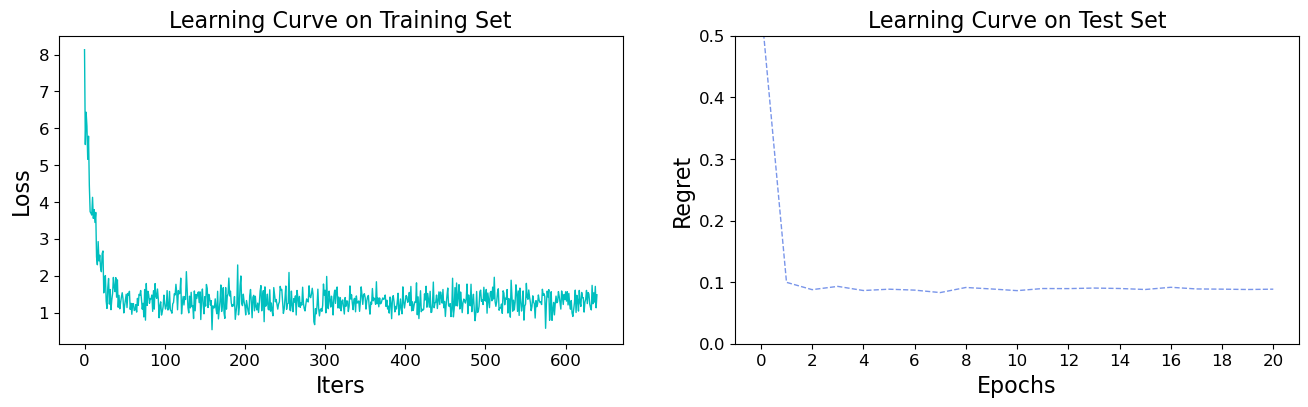

In [31]:
visLearningCurve(loss_log, loss_log_regret)

Differentiable Black-Box Solver

In [33]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.blackboxOpt`` allows us to set a differentiable solver, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``lambd``: a parameter to contral interpolation degree
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores

In [35]:
# init dbb solver
dbb = pyepo.func.blackboxOpt(optmodel, lambd=20, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function
def dbbl1(cp, c, z):
    # black-box optimizer
    wp = dbb(cp)
    # objective value
    zp = (wp * c).sum(1).view(-1, 1)
    # loss
    loss = l1(zp, z)
    return loss

Num of cores: 2


Entrenamiento

In [37]:
loss_log, loss_log_regret = trainModel(reg, loss_func=dbbl1, method_name="dbb")

Epoch  1,  Loss:    1.2131,  Regret: 20.5102%
Epoch  2,  Loss:    0.6763,  Regret: 14.3138%
Epoch  3,  Loss:    0.3816,  Regret: 11.2442%
Epoch  4,  Loss:    1.0846,  Regret: 12.9576%
Epoch  5,  Loss:    0.3032,  Regret: 11.4306%
Epoch  6,  Loss:    0.5123,  Regret: 12.4578%
Epoch  7,  Loss:    1.7694,  Regret: 13.0731%
Epoch  8,  Loss:    0.7392,  Regret: 13.8237%
Epoch  9,  Loss:    0.3060,  Regret: 13.2482%
Epoch 10,  Loss:    0.2623,  Regret: 14.9414%
Epoch 11,  Loss:    0.1668,  Regret: 13.0805%
Epoch 12,  Loss:    0.3339,  Regret: 13.5494%
Epoch 13,  Loss:    0.0985,  Regret: 12.5773%
Epoch 14,  Loss:    0.3177,  Regret: 11.9482%
Epoch 15,  Loss:    0.4737,  Regret: 14.7784%
Epoch 16,  Loss:    0.3348,  Regret: 14.7589%
Epoch 17,  Loss:    0.5471,  Regret: 15.1402%
Epoch 18,  Loss:    0.3512,  Regret: 19.7481%
Epoch 19,  Loss:    0.5233,  Regret: 16.8145%
Epoch 20,  Loss:    0.4208,  Regret: 15.5499%
Total Elapsed Time: 1846.93 Sec.


Curva de aprendizaje

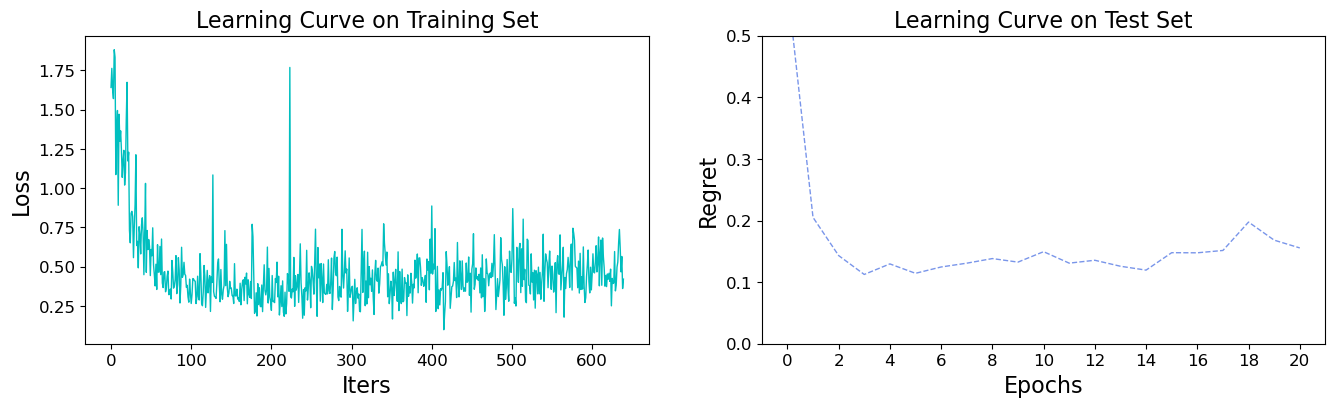

In [39]:
visLearningCurve(loss_log, loss_log_regret)

-Differentiable Perturbed Optimizer 

In [41]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.perturbedOpt`` allows us to set a SPO+ loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

In [43]:
# init ptb solver
ptb = pyepo.func.perturbedOpt(optmodel, n_samples=3, sigma=1.0, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function se tiene que definir un funcion de perdida ya que en ptb no viene incluida
def ptbl1(cp, w):
    # perturbed optimizer
    we = ptb(cp)
    # loss
    loss = l1(we, w)
    return loss

Num of cores: 2


In [44]:
loss_log, loss_log_regret = trainModel(reg, loss_func=ptbl1, method_name="ptb")

Epoch  1,  Loss:    0.2500,  Regret: 45.0341%
Epoch  2,  Loss:    0.2250,  Regret: 33.3582%
Epoch  3,  Loss:    0.2521,  Regret: 26.7180%
Epoch  4,  Loss:    0.2313,  Regret: 22.6520%
Epoch  5,  Loss:    0.2604,  Regret: 19.7769%
Epoch  6,  Loss:    0.2229,  Regret: 18.3252%
Epoch  7,  Loss:    0.1563,  Regret: 17.3565%
Epoch  8,  Loss:    0.1729,  Regret: 16.7648%
Epoch  9,  Loss:    0.2417,  Regret: 16.1949%
Epoch 10,  Loss:    0.2062,  Regret: 15.8968%
Epoch 11,  Loss:    0.2333,  Regret: 15.3650%
Epoch 12,  Loss:    0.2000,  Regret: 14.8874%
Epoch 13,  Loss:    0.1708,  Regret: 14.4968%
Epoch 14,  Loss:    0.1854,  Regret: 14.4646%
Epoch 15,  Loss:    0.2125,  Regret: 14.2381%
Epoch 16,  Loss:    0.1521,  Regret: 13.5122%
Epoch 17,  Loss:    0.1979,  Regret: 12.8568%
Epoch 18,  Loss:    0.1854,  Regret: 12.6024%
Epoch 19,  Loss:    0.2479,  Regret: 12.2436%
Epoch 20,  Loss:    0.2104,  Regret: 12.4787%
Total Elapsed Time: 2086.23 Sec.


Curva de apredizaje

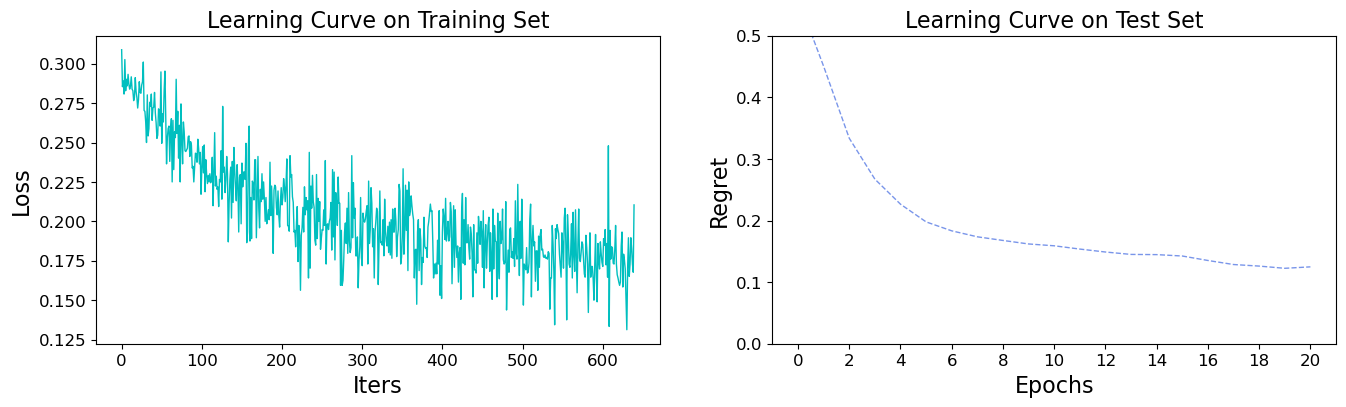

In [46]:
visLearningCurve(loss_log, loss_log_regret)

Perturbed Fenchel-Young Loss 

In [48]:
pfy = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=10, sigma=0.5, processes=2)

Num of cores: 2


In [49]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.perturbedFenchelYoung`` allows us to set a Fenchel-Young loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

In [51]:
# init pfyl loss
pfy = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0, processes=2)

Num of cores: 2


Entrenamiento

In [53]:
loss_log, loss_log_regret = trainModel(reg, loss_func=pfy, method_name="pfy")

Epoch  1,  Loss:    5.3889,  Regret: 12.1028%
Epoch  2,  Loss:    4.9722,  Regret:  9.0904%
Epoch  3,  Loss:    3.3611,  Regret:  8.5426%
Epoch  4,  Loss:    2.6389,  Regret:  8.6269%
Epoch  5,  Loss:    5.5556,  Regret:  8.7296%
Epoch  6,  Loss:    5.2222,  Regret:  8.6573%
Epoch  7,  Loss:    4.3056,  Regret:  8.7135%
Epoch  8,  Loss:    6.4444,  Regret:  8.4331%
Epoch  9,  Loss:    4.7222,  Regret:  8.5971%
Epoch 10,  Loss:    7.1667,  Regret:  8.7059%
Epoch 11,  Loss:    3.4722,  Regret:  8.4266%
Epoch 12,  Loss:    4.2778,  Regret:  8.5664%
Epoch 13,  Loss:    2.8889,  Regret:  8.5247%
Epoch 14,  Loss:    3.5556,  Regret:  8.5919%
Epoch 15,  Loss:    3.1111,  Regret:  8.2359%
Epoch 16,  Loss:    4.4444,  Regret:  8.6465%
Epoch 17,  Loss:    5.3333,  Regret:  8.6565%
Epoch 18,  Loss:    6.0556,  Regret:  8.7232%
Epoch 19,  Loss:    6.0556,  Regret:  8.7964%
Epoch 20,  Loss:    4.7222,  Regret:  8.3444%
Total Elapsed Time: 2116.56 Sec.


Curva de aprendizaje

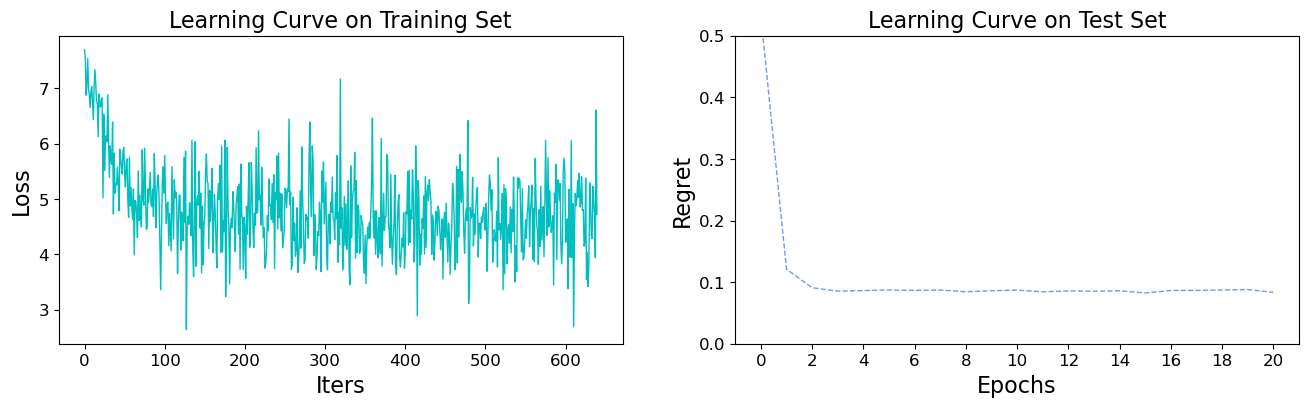

In [55]:
visLearningCurve(loss_log, loss_log_regret)